### Experiments to demonstrate that weights evolve via D2 given signal and no noise 
A (0-layer) neural network that uses a smooth nonlinear activation like tanh and trains its weights using backpropagation will cause weights to shift by D2(z) := tanh(z)*(d/dt tanh(z)). For this analysis, we substitute changing weights with changing weights-divided-by-x-value, leaving us with only the composites.

Section 1:
- For each nonlinearity of interest, 
 - For each target value y_i,
   - For each v_i in a region of interest,
     - Compute and display the error-signal-based gradient update that a v_i would have received.

In [1]:
%matplotlib inline
# ^ enables usage of matplotlib and furthermore enables displaying it in the notebook

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f043txkk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

Manually create D2 and D4 of functions:

In [32]:
def tanh(x): return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
def d2_tanh(x,y=0): return -(y-tanh(x))*(1-tanh(x)**2) 
def sech(x): return 2/(np.exp(x)+np.exp(-x))
def d4_tanh(x,y=0): return -2*sech(x)**2*tanh(x) - 6*sech(x)**4*tanh(x) + 6*sech(x)**2*tanh(x)**3


Plotters convenience function:

In [33]:
def Plot(f, vals=V_values, color=None): 
    if color==None: plt.plot(vals, [f(v) for v in vals])
    else: plt.plot(vals, [f(v) for v in vals], color=color)

Sanity check; plot tanh, its D2, its D4

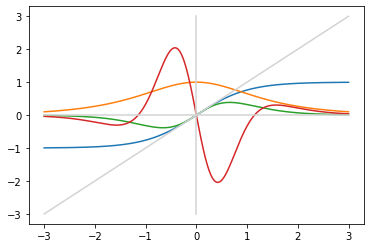

In [35]:
V_values = np.linspace(-3,3,100*(3--3)+1)

Plot(tanh)
Plot(sech)
Plot(d2_tanh)
Plot(d4_tanh)
Plot(lambda x:0, color='lightgray')
Plot(lambda x:x, color='lightgray')
plt.plot([0,0],[-3,3], color='lightgray')

start of Section 1. First, delimit parameters; concurrently, initialize network;

In [164]:
# delimit parameters
Nonlinearities = [ ('tanh',tanh) ]                  # s_counter
Y_values = [0,-1,1]                                 # y_counter
V_values = np.linspace(-3,3,100*(3--3)+1)           # v_counter
X_data = [ np.ones(v.shape) for v in V_values ]     # x_counter

learning_rate=1e0
V_values[:1], V_values.shape

(array([-3.]), (601,))

In [159]:
def Set_weights(layer, weights):
    layer.set_weights([np.expand_dims(weights,0).T])
    
# initialize a network whose weights we manually set
def init_manual_model(nonlinearity, weight_value, learning_rate=0.01):
    nonlinearity_name, nonlinearity_function=nonlinearity
    model = Sequential()
    model.add(
        Dense(
            1, # num output units
            kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
            input_shape=(1,),
            activation=nonlinearity_name,
            use_bias=False,
        )
    )
    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )
    Set_weights(model.layers[0], weight_value)
    return model
test_model_init=init_manual_model(Nonlinearities[0], V_values[:1])
# [l.get_config() for l in test_model_init.layers]


[{'name': 'dense_59',
  'trainable': True,
  'batch_input_shape': (None, 1),
  'dtype': 'float32',
  'units': 1,
  'activation': 'tanh',
  'use_bias': False,
  'kernel_initializer': {'class_name': 'Zeros', 'config': {}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None}]

In [178]:
def query_manual_model():
    dev_model=init_manual_model(Nonlinearities[0], np.zeros((1,))) # tmp: only combo
    weights_inbox = []
    changes_inbox = []
    weights_to_changes = []
    
    # counters. vi: different values of vi
    
    
    
    for v_counter in range(V_values.shape[0]):
        Set_weights(dev_model.layers[0], V_values[v_counter:v_counter+1])
        
        weights_retreiver = LambdaCallback( \
                on_epoch_begin=lambda batch, logs: weights_inbox.append( dev_model.layers[0].get_weights()[0]))
        changes_retriever = LambdaCallback( 
                on_epoch_end  =lambda batch, logs: changes_inbox.append( dev_model.layers[0].get_weights()[0]))        
        dev_model.fit(
            np.array([ X_data[0] ]),     # one datapoint for now   x_counter
            np.array([ Y_values[0] ]),   # one datapoint for now.  y_counter
            batch_size=1,
            epochs=1,
            callbacks=[weights_retreiver, changes_retriever], 
            verbose=0
        )
        change = changes_inbox[-1]-weights_inbox[-1]
        weights_to_changes.append( (weights_inbox[-1][0][0], change[0][0]) )
        if v_counter % int(V_values.shape[0]//10) == 0:
            print('iteration '+str(v_counter)+'/'+str(V_values.shape[0])+' done')
        #if v_counter>5: break
#     print(weights_inbox)
#     print()
#     print(changes_inbox)
#     print()
#     print(weights_to_changes)
    return weights_to_changes

wtc=query_manual_model()

iteration 0/601done
iteration 60/601done
iteration 120/601done
iteration 180/601done
iteration 240/601done
iteration 300/601done
iteration 360/601done
iteration 420/601done
iteration 480/601done
iteration 540/601done
iteration 600/601done


Text(0.5, 1.0, 'same curves!')

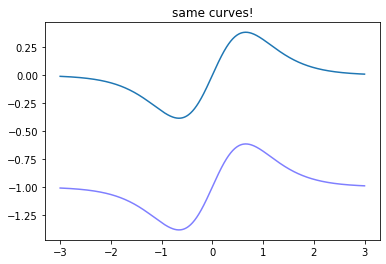

In [191]:
plt.plot([w[0] for w in wtc], [w[1]*-50-1 for w in wtc], color=[0,0,1,0.5])
#plt.plot(V_values, [d2_tanh(x) for x in V_values], color=[1,0,0,0.5])
Plot(d2_tanh)
plt.title('same curves!')

In [113]:
x = np.array([1,2,3])
x=np.expand_dims(x,axis=0)
x.shape
# //
# sorted(dev_model.layers[0].__dir__())   prints
dev_model.layers[0].get_weights()
help(dev_model.fit)

[array([[-3.],
        [-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.],
        [ 3.]], dtype=float32)]

In [67]:
#tf.keras.initializers.__dir__()
# help(tf.keras.initializers.zeros)
help(tf.optimizers.SGD)

Help on class SGD in module keras.optimizer_v2.gradient_descent:

class SGD(keras.optimizer_v2.optimizer_v2.OptimizerV2)
 |  SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs)
 |  
 |  Gradient descent (with momentum) optimizer.
 |  
 |  Update rule for parameter `w` with gradient `g` when `momentum` is 0:
 |  
 |  ```python
 |  w = w - learning_rate * g
 |  ```
 |  
 |  Update rule when `momentum` is larger than 0:
 |  
 |  ```python
 |  velocity = momentum * velocity - learning_rate * g
 |  w = w + velocity
 |  ```
 |  
 |  When `nesterov=True`, this rule becomes:
 |  
 |  ```python
 |  velocity = momentum * velocity - learning_rate * g
 |  w = w + momentum * velocity - learning_rate * g
 |  ```
 |  
 |  Args:
 |    learning_rate: A `Tensor`, floating point value, or a schedule that is a
 |      `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
 |      that takes no arguments and returns the actual value to use. The
 |      learning rate. De

In [14]:
savefig_utf_timestamp=dt.now().strftime('%m_%d-%H_%M_%S')
print(savefig_utf_timestamp)
#plt.savefig('figures/fig_'+savefig_utf_timestamp)
plt.show()

07_11-22_19_13
